<a href="https://colab.research.google.com/github/algo74/MLCourse/blob/master/HW2/HW2_file7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2. Fine tuning data augmentation



* using the best model so far ( file 3 network 2 *i.e.* network 4 from file 4 *i.e.* network 1 from file 5)
* using the parameters for data augmentation presented in class

## Credits

* Based on file 5
* using the parameters for data augmentation presented in class

## Loading the CIFAR10 data set

In [1]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 62s 0us/step


## Preparing the data

In [0]:
from keras.utils import to_categorical

orig_tr_y = to_categorical(train_labels)

test_y = to_categorical(test_labels)

orig_tr_x = train_images.astype('float32') / 255

test_x = test_images.astype('float32') / 255 

class_names = ['airplan', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Splitting original train set into smaller train and validate sets

In [0]:
import numpy as np
# we want to split "randomly" but reproducible
np.random.seed(1000)
m=len(orig_tr_x)
m_tr = int(m * 0.8) 
m_val = m - m_tr
shuffled_indices = np.random.permutation(m)
orig_tr_x_s = orig_tr_x[shuffled_indices]
orig_tr_y_s = orig_tr_y[shuffled_indices]
# splitting
tr_x = orig_tr_x_s[:m_tr]
tr_y = orig_tr_y_s[:m_tr]
val_x = orig_tr_x_s[m_tr:]
val_y = orig_tr_y_s[m_tr:]
#print(len(tr_x), m_tr)
#print(len(val_x), m_val)

## Setting up Keras and general structure of networks

### A few things to beautify outputs

In [0]:
from IPython.display import HTML, display
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import time

def plot_fit_history(history):
  tr_acc = history['acc']
  val_acc = history['val_acc']
  tr_loss = history['loss']
  val_loss = history['val_loss']
  epochs_range = range(1, len(tr_acc) + 1)
  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss', color=color)
  l1, = ax1.plot(epochs_range, tr_loss, 's:', color=color, label='Training Loss', markeredgewidth=1, fillstyle='none')
  l2, = ax1.plot(epochs_range, val_loss, 'o-', color=color, label='Validation Loss')
  ax1.tick_params(axis='y', labelcolor=color, grid_color=color, grid_linestyle=':')

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
  l3, = ax2.plot(epochs_range, tr_acc, 's:', color=color, label='Training Acc', markeredgewidth=1, fillstyle='none')
  l4, = ax2.plot(epochs_range, val_acc, 'o-', color=color, label='Validation Acc')
  ax2.tick_params(axis='y', labelcolor=color, grid_color=color, grid_linestyle=':')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  
  plt.legend((l1, l2, l3, l4), ('Training Loss', 'Validation Loss', 'Training Acc', 'Validation Acc'), loc=(1.2,0.5))
  plt.show()

# https://stackoverflow.com/questions/46939393/how-do-i-use-updatable-displays-on-colab
def progress(hook):
    epoch = hook.ep
    elTime = time.strftime("%H:%M:%S", time.gmtime(time.time() - hook.start_time))
    return HTML("""
        <progress
            value='{epoch}'
            max='{maxEpoch}',
            style='width: 80%'
        >
            {epoch}
        </progress>
        <p>{epoch} of {maxEpoch} epochs complete<br> Time elapsed: {elTime}<br> Training Loss: {trLoss}<br> Training Acc.: {trAcc}<br> Validation Loss: {valLoss}<br> Validation Acc.: {valAcc}</p>
    """.format(epoch=epoch, maxEpoch=hook.params['epochs'], valAcc=hook.val_acc, valLoss=hook.val_loss, trAcc=hook.tr_acc, trLoss=hook.tr_loss, elTime=elTime))
                       
class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        #print (self.params)
        self.start_time = time.time()
        self.val_acc = 'N/A'
        self.tr_acc = 'N/A'
        self.val_loss = 'N/A'
        self.tr_loss = 'N/A'
        self.ep = 0
        self.pr_bar = display(progress(self), display_id=True)
    def on_epoch_end(self, batch, logs={}):
        self.val_acc = (logs.get('val_acc'))
        self.tr_acc = (logs.get('acc'))
        self.tr_loss = logs.get('loss')
        self.val_loss = logs.get('val_loss')
        self.ep += 1
        self.pr_bar.update(progress(self))
        
    
    

### Common network features

In [5]:
from keras import models, layers
import keras

input_shape = tr_x.shape[1:]
print("Input shape:", input_shape)
n_classes = len(class_names)
print("Number of classes:", n_classes)

epochs = 100
batch_size = 128
learnig_rate = 0.1

myHook = AccuracyHistory()

# let's try variable learing rate
sgd = keras.optimizers.SGD(lr=learnig_rate)
change_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=5, factor=0.3, verbose=1, min_lr=0.0001)

cbks = [myHook, change_lr]

Input shape: (32, 32, 3)
Number of classes: 10
Instructions for updating:
Colocations handled automatically by placer.


### Data augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             rotation_range=40,
                             fill_mode='nearest')

# datagen.fit(tr_x)

### Training function

In [0]:
def train(network, ep=epochs, bs = batch_size):
#   history = network.fit(tr_x, 
#                       tr_y, 
#                       epochs=ep, 
#                       batch_size=bs, 
#                       verbose=0,
#                       validation_data=(val_x, val_y),
#                       callbacks=[myHook])
  history = network.fit_generator(datagen.flow(tr_x, tr_y, batch_size=bs),
                    steps_per_epoch=len(tr_x) // bs,
                    epochs=ep,
                    callbacks=cbks,
                    verbose=0,
                    validation_data=(val_x, val_y))
  plot_fit_history(history.history)
  return history

## Network 1
* file 3 network 2 *i.e.* network 4 from file 4 *i.e.* network 1 from file 5
* the "best network"

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 128)       147584    
___________________________

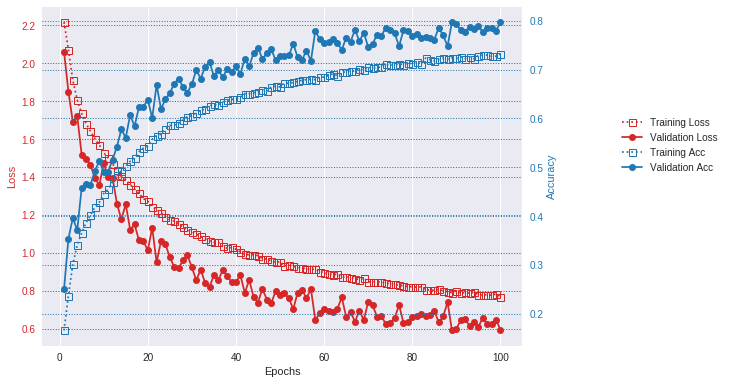

In [0]:
network = models.Sequential()
network.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
network.add(layers.Conv2D(64, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
network.add(layers.Dropout(0.25))
network.add(layers.Conv2D(128, (3, 3), activation='relu'))
network.add(layers.Conv2D(128, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D(pool_size=(2, 2)))
network.add(layers.Dropout(0.25))
network.add(layers.Flatten())
network.add(layers.Dense(1024, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(n_classes, activation='softmax'))
network.summary()
network.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
h = train(network)


Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.030000000447034835.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.009000000357627868.

Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.002700000163167715.

Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.0008100000210106373.

Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.00024299999931827186.

Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0001.


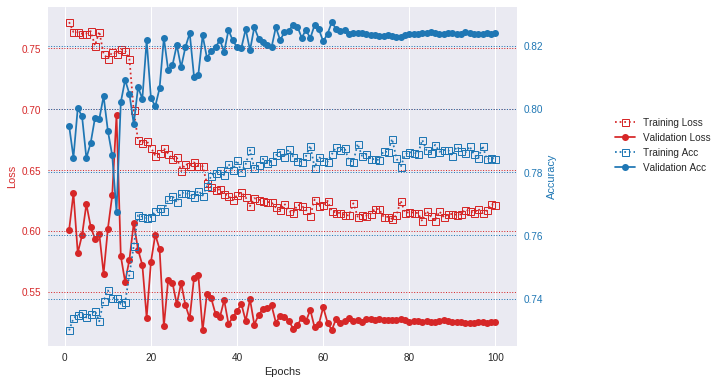

In [0]:
h = train(network)

### Result

After over 200 epochs, the accuracy on the validation set reached ~82%. The accuracy on the training set was only 78.5%.

These settings of data augmentation are too wide for this network, but maybe a more deeper network can handle such an input and better predict the validation set

## Network 2
* file 6 network 1
* the "more deeper network"

In [8]:
network = models.Sequential()
network.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
network.add(layers.Conv2D(64, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D(pool_size=(2, 2)))
network.add(layers.Conv2D(128, (3, 3), activation='relu'))
network.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
network.add(layers.MaxPooling2D(pool_size=(2, 2)))
network.add(layers.Dropout(0.1))
network.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
network.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
network.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
network.add(layers.MaxPooling2D(pool_size=(2, 2)))
network.add(layers.Dropout(0.1))
network.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
network.add(layers.Conv2D(512, (3, 3), activation='relu'))
network.add(layers.Dropout(0.1))
network.add(layers.Flatten())
network.add(layers.Dense(4096, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(4096, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(n_classes, activation='softmax'))
network.summary()
network.compile(optimizer=keras.optimizers.SGD(lr=learnig_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
___________________________

In [9]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
file_prefix = '/gdrive/My Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# if network is not a model then restore network from file_name, else use network as is
# after training save network to file_name
def train_and_save(network, file_name, ep=epochs, bs = batch_size):
  
  if not isinstance(network, keras.models.Sequential):
    network = keras.models.load_model(file_name)
    print('Loaded model from ' + file_name)
  
  train(network, ep, bs)
  
  network.save(file_name)
  print('Saved model to ' + file_name)

Instructions for updating:
Use tf.cast instead.


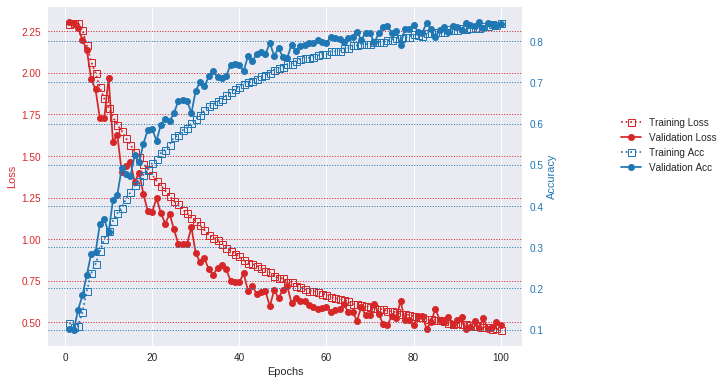

Saved model to /gdrive/My Drive/file7n2.h5


In [11]:
file_name = file_prefix + "file7n2.h5"
train_and_save(network, file_name)


Epoch 00066: ReduceLROnPlateau reducing learning rate to 0.030000000447034835.

Epoch 00082: ReduceLROnPlateau reducing learning rate to 0.009000000357627868.

Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.002700000163167715.


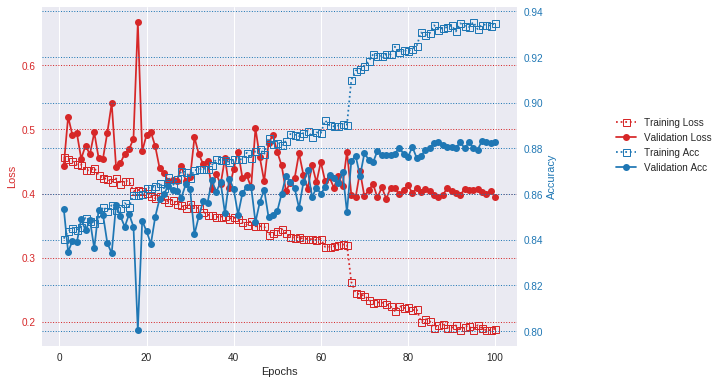

Saved model to /gdrive/My Drive/file7n2.h5


In [12]:
train_and_save(network, file_name)


Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0008100000210106373.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00024299999931827186.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0001.


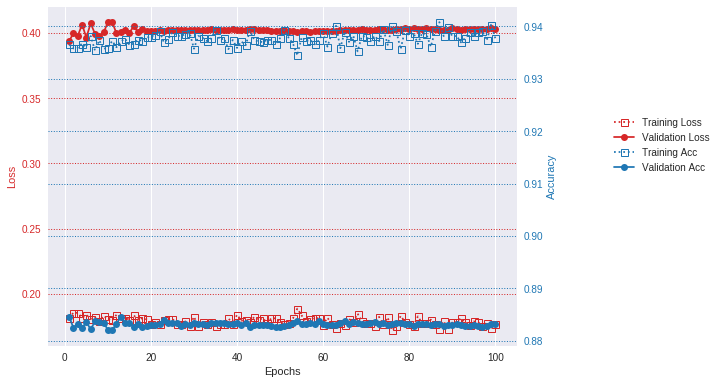

Saved model to /gdrive/My Drive/file7n2.h5


In [13]:
train_and_save(network, file_name)